In [1]:
from common.torch_utils import get_available_device

device = get_available_device()

Platform: Darwin
Release: 21.5.0
MPS available: True
CUDA available: False
Selected device: mps


## Model

In [2]:
from fcos.backbone import build_backbone

backbone = build_backbone('resnet50')
backbone

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [3]:
from fcos.feature_extractor import FeatureExtractor

fext = FeatureExtractor(backbone)

In [4]:
import torch


random_input = torch.rand((1, 3, 512, 512), dtype=torch.float)
for k, v in fext(random_input).items():
    print(k, v.shape)

P3 torch.Size([1, 256, 64, 64])
P4 torch.Size([1, 256, 32, 32])
P5 torch.Size([1, 256, 16, 16])
P6 torch.Size([1, 256, 8, 8])
P7 torch.Size([1, 256, 4, 4])


[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


In [5]:
from fcos.heads import ClassificationHead, RegressionHead

In [6]:
regr_head = RegressionHead()
regr_head(torch.rand((1, 256, 240, 320), dtype=torch.float32)).shape

torch.Size([1, 4, 240, 320])

In [7]:
clf_head = ClassificationHead(2)
[x.shape for x in clf_head(torch.rand((1, 256, 64, 64), dtype=torch.float32))]

[torch.Size([1, 2, 64, 64]), torch.Size([1, 1, 64, 64])]

## Arch - all together

In [8]:
from fcos.core import FcosCore

In [9]:
model = FcosCore(backbone, 3)
model

FcosCore(
  (_fext): FeatureExtractor(
    (_backbone): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReL

In [10]:
rand_input = torch.rand((4, 3, 256, 256), dtype=torch.float32)
rand_input.shape

torch.Size([4, 3, 256, 256])

In [11]:
out = model(rand_input)

In [12]:
for k, ((cls, cntr), r) in out.items():
    print(k, cls.shape, cntr.shape, r.shape)

P3 torch.Size([4, 3, 32, 32]) torch.Size([4, 1, 32, 32]) torch.Size([4, 4, 32, 32])
P4 torch.Size([4, 3, 16, 16]) torch.Size([4, 1, 16, 16]) torch.Size([4, 4, 16, 16])
P5 torch.Size([4, 3, 8, 8]) torch.Size([4, 1, 8, 8]) torch.Size([4, 4, 8, 8])
P6 torch.Size([4, 3, 4, 4]) torch.Size([4, 1, 4, 4]) torch.Size([4, 4, 4, 4])
P7 torch.Size([4, 3, 2, 2]) torch.Size([4, 1, 2, 2]) torch.Size([4, 4, 2, 2])


## Dataloader

In [13]:
from dataset.loader import build_dataloader

train_dataloader = build_dataloader('train', batch_size=4)

img, boxes, labels = next(iter(train_dataloader))

/Users/iolkhovsky/Documents/repos/fcos/dataset/loader.py:59: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  return torch.Tensor(images), bboxes, labels


In [14]:
img.shape

torch.Size([4, 256, 256, 3])

In [15]:
boxes

[tensor([[  0.0000,  69.4520, 163.6066, 201.4026]]),
 tensor([[ 87.6720, 111.9573, 256.0000, 209.5787],
         [ 42.6600, 197.2907, 256.0000, 256.0000]]),
 tensor([[  0.0000,   0.0000, 193.4872, 256.0000]]),
 tensor([[ 22.4168, 107.0301, 194.6314, 256.0000],
         [ 40.0083,  66.1483, 251.1257, 256.0000],
         [  0.0000,   0.0000, 123.7335, 201.4192],
         [  0.0000,   9.3232,  86.0102, 194.3930]])]

In [16]:
labels

[tensor([17], dtype=torch.int32),
 tensor([6, 2], dtype=torch.int32),
 tensor([4], dtype=torch.int32),
 tensor([ 2,  0,  0, 17], dtype=torch.int32)]

## Detections codec

In [17]:
from fcos.codec import DetectionsCodec
import numpy as np


codec = DetectionsCodec(img_res=(10, 10), fmap_res=(3, 3), classes=3)


boxes = [
    [0, 1, 1, 8.5, 8.5, 0],
    [0, 1, 1, 4, 5, 2],
    [2, 1.1, 1.2, 5.7, 6.6, 1],
]
boxes = torch.Tensor(np.asarray(boxes, dtype=np.float32))
encoded_vector = codec.encode(boxes)
encoded_vector
back = codec.decode(encoded_vector)
back

tensor([[0.0000, 1.0000, 1.0000, 4.0000, 5.0000, 0.2390, 0.0000, 0.2390],
        [0.0000, 1.0000, 1.0000, 8.5000, 8.5000, 0.2922, 0.0000, 0.0000],
        [0.0000, 1.0000, 1.0000, 8.5000, 8.5000, 0.0471, 0.0000, 0.0000],
        [0.0000, 1.0000, 1.0000, 4.0000, 5.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 1.0000, 8.5000, 8.5000, 0.8750, 0.0000, 0.0000],
        [0.0000, 1.0000, 1.0000, 8.5000, 8.5000, 0.1410, 0.0000, 0.0000],
        [0.0000, 1.0000, 1.0000, 8.5000, 8.5000, 0.0471, 0.0000, 0.0000],
        [0.0000, 1.0000, 1.0000, 8.5000, 8.5000, 0.1410, 0.0000, 0.0000],
        [0.0000, 1.0000, 1.0000, 8.5000, 8.5000, 0.0227, 0.0000, 0.0000],
        [2.0000, 1.1000, 1.2000, 5.7000, 6.6000, 0.0000, 0.1153, 0.0000],
        [2.0000, 1.1000, 1.2000, 5.7000, 6.6000, 0.0000, 0.1303, 0.0000],
        [2.0000, 1.1000, 1.2000, 5.7000, 6.6000, 0.0000, 0.2432, 0.0000],
        [2.0000, 1.1000, 1.2000, 5.7000, 6.6000, 0.0000, 0.2749, 0.0000]])

## Draft for training loop

In [18]:
train_dataset = build_dataloader('train', batch_size=4)

In [19]:
img, boxes, labels = next(iter(train_dataloader))
print(img.shape)
print(boxes)
print(labels)

torch.Size([4, 256, 256, 3])
[tensor([[ 51.5075,  90.9840, 212.1802, 245.3520],
        [ 94.5586,   0.0000, 206.0300, 185.4480],
        [ 57.6577,   1.8960, 115.3153, 169.3200]]), tensor([[107.4460,  86.0160, 135.4080, 108.5440]]), tensor([[  0.0000,  64.2166, 256.0000, 256.0000]]), tensor([[ 11.3927,   0.0000, 255.3298, 256.0000]])]
[tensor([8, 0, 0], dtype=torch.int32), tensor([14], dtype=torch.int32), tensor([14], dtype=torch.int32), tensor([17], dtype=torch.int32)]


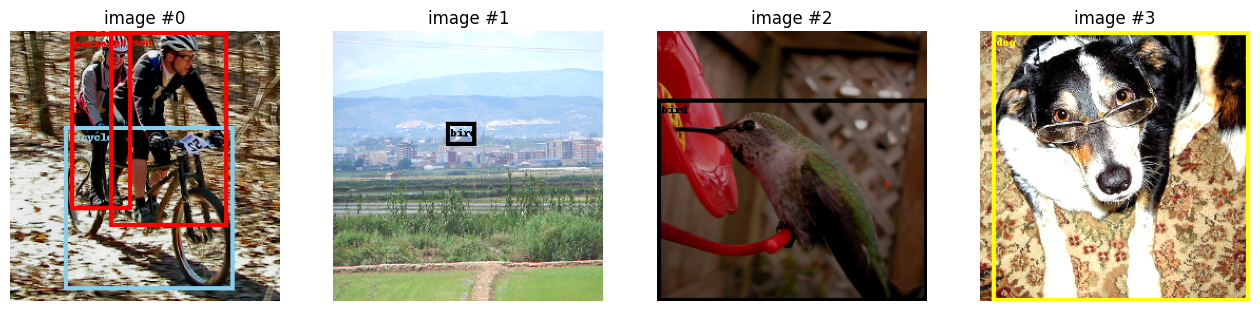

In [20]:
from dataset.visualization import visualize_batch
from dataset.labels_codec import LabelsCodec

visualize_batch(img, boxes, labels, codec=LabelsCodec())

## Full model

In [21]:
import numpy as np

from fcos.preprocessor import FcosPreprocessor


labels_codec = LabelsCodec()
print("Labels", len(labels_codec))
img_res = (512, 512)
print("Resolution", img_res)

preprocessor = FcosPreprocessor(img_res)
preprocessor_outputs, scales = preprocessor(img)
print("Preprocessor", preprocessor_outputs.shape)

core = FcosCore(backbone, len(labels_codec))
core_outputs = core(preprocessor_outputs)
print("Core")
for k, ((cls, cntr), r) in core_outputs.items():
    print(k, cls.shape, cntr.shape, r.shape)

feature_maps = {
    'P3': (64, 64),
    'P4': (32, 32),
    'P5': (16, 16),
    'P6': (8, 8),
    'P7': (4, 4),
}

Labels 20
Resolution (512, 512)
Preprocessor torch.Size([4, 3, 512, 512])
Core
P3 torch.Size([4, 20, 64, 64]) torch.Size([4, 1, 64, 64]) torch.Size([4, 4, 64, 64])
P4 torch.Size([4, 20, 32, 32]) torch.Size([4, 1, 32, 32]) torch.Size([4, 4, 32, 32])
P5 torch.Size([4, 20, 16, 16]) torch.Size([4, 1, 16, 16]) torch.Size([4, 4, 16, 16])
P6 torch.Size([4, 20, 8, 8]) torch.Size([4, 1, 8, 8]) torch.Size([4, 4, 8, 8])
P7 torch.Size([4, 20, 4, 4]) torch.Size([4, 1, 4, 4]) torch.Size([4, 4, 4, 4])


In [22]:
from fcos.postprocessor import FcosPostprocessor    


proc = FcosPostprocessor(img_res, feature_maps, labels_codec)
res = proc(core_outputs)
print('Postprocessor:')
# res

Postprocessor:


/Users/iolkhovsky/Documents/repos/fcos/fcos/postprocessor.py:25: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  [torch.reshape(torch.range(0, h * w - 1), (1, 1, h * w))] * b,


In [23]:
res.shape

torch.Size([4, 5456, 24])

In [24]:
from fcos.model import FCOS


labels_codec = LabelsCodec()
print("Labels", len(labels_codec))
img_res = (512, 512)
print("Resolution", img_res)
    
full_model = FCOS(backbone, labels_codec, img_res)


Labels 20
Resolution (512, 512)


In [25]:
full_model

FCOS(
  (_preprocessor): FcosPreprocessor(
    (_normalize): Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  )
  (_core): FcosCore(
    (_fext): FeatureExtractor(
      (_backbone): ResNet(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(64, 256,

In [26]:
res = full_model(img)
res.shape

torch.Size([4, 5456, 24])

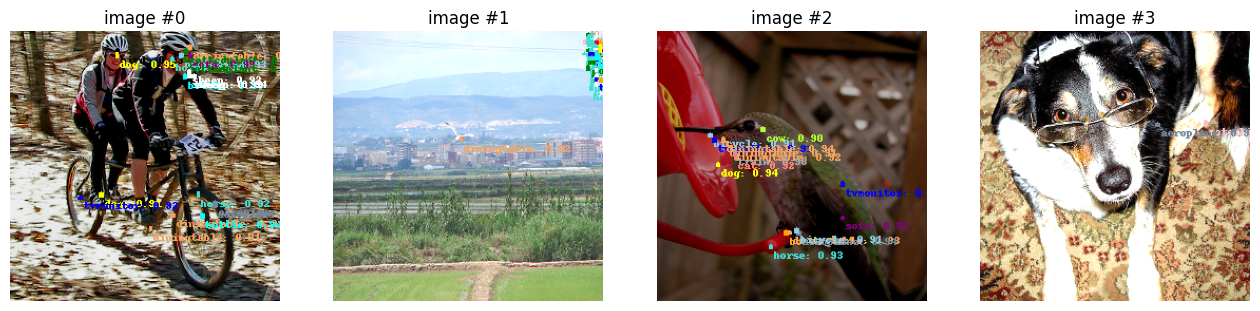

In [27]:
def draw_all_detections(imgs_batch, prediction, labels_codec, threshold=0.01):  
    boxes = []
    labels = []
    scores = []

    for img_pred in prediction:
        max_scores, max_indices = torch.max(img_pred[:, 4:], axis=1)
        mask = max_scores > threshold
        filtered_detections = img_pred[mask]
        
        img_boxes, img_labels, img_scores = [], [], []
        for detection_vector in filtered_detections:
            img_boxes.append(detection_vector[:4])
            label = torch.argmax(detection_vector[4:])
            img_labels.append(label)
            img_scores.append(detection_vector[4 + label])
        
        if len(img_boxes):
            img_boxes = torch.stack(img_boxes)
            img_labels = torch.tensor(img_labels)
            img_scores = torch.tensor(img_scores)
        else:
            img_boxes = torch.zeros((0, 4), dtype=torch.float)
            img_labels = torch.zeros((0, 1), dtype=torch.float)
            img_scores = torch.zeros((0, 1), dtype=torch.float)
        
        boxes.append(img_boxes)
        labels.append(img_labels)
        scores.append(img_scores)   

    visualize_batch(
        imgs_batch,
        boxes_batch=boxes,
        labels_batch=labels,
        scores_batch=scores,
        codec=labels_codec
    )

draw_all_detections(img, res, labels_codec, 0.9)

In [28]:
res.shape

torch.Size([4, 5456, 24])

In [29]:
labels, boxes

([tensor([8, 0, 0], dtype=torch.int32),
  tensor([14], dtype=torch.int32),
  tensor([14], dtype=torch.int32),
  tensor([17], dtype=torch.int32)],
 [tensor([[ 51.5075,  90.9840, 212.1802, 245.3520],
          [ 94.5586,   0.0000, 206.0300, 185.4480],
          [ 57.6577,   1.8960, 115.3153, 169.3200]]),
  tensor([[107.4460,  86.0160, 135.4080, 108.5440]]),
  tensor([[  0.0000,  64.2166, 256.0000, 256.0000]]),
  tensor([[ 11.3927,   0.0000, 255.3298, 256.0000]])])

## Loss function

### Classification (Focal)

### Regression (IoU)

### Centerness (BCE)